In [1]:
%matplotlib inline
import seaborn
import numpy, scipy, scipy.spatial, matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 2)

[&larr; Back to Index](index.html)

# Dynamic Time Warping 

(Credit for some of the ideas in this notebook come from [FastDTW](https://github.com/slaypni/fastdtw/blob/master/fastdtw.py).)

Dynamic time warping (DTW) is an algorithm used to align two sequences of similar content but possibly different lengths. For example, you might want to align two different performances of the same musical work. These two signals, $x$ and $y$, may have similar sequences of chord progressions and instrumentations, but there may be timing deviations between the two.

Given two sequences, $x[n], n \in \{0, ..., N_x - 1\}$, and $y[n], n \in \{0, ..., N_y - 1\}$, DTW produces a set of index pairs $\{ (i, j) ... \}$ such that $x[i]$ and $y[j]$ are similar.

## Example

Create two arrays, $x$ and $y$, of lengths $N_x$ and $N_y$, respectively.

In [2]:
x = scipy.array([3, 3, 1, 4, 6, 1, 5, 5])
y = scipy.array([4, 2, 1, 3, 3, 4, 1, 4, 5])
Nx = len(x)
Ny = len(y)
print Nx, Ny

8 9


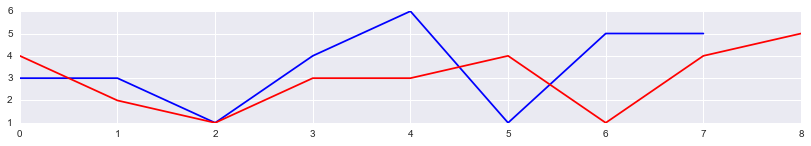

In [3]:
plt.plot(range(Nx), x, 'b', range(Ny), y, 'r')

In this simple example, there is only one value or "feature" at each time index. However, in practice, you can use sequences of *vectors*, e.g. spectrograms, chromagrams, or MFCC-grams.

But for now, we will add an empty dimension to the array because DTW expects a vector at each time index -- in this simple example, a "one-dimensional vector", i.e. a scalar.

In [4]:
x = scipy.expand_dims(x, axis=1)
y = scipy.expand_dims(y, axis=1)
print x.shape
print y.shape

(8, 1)
(9, 1)


In [5]:
print x

[[3]
 [3]
 [1]
 [4]
 [6]
 [1]
 [5]
 [5]]


## Step 1: Compute pairwise distances

Compute a matrix of pairwise distances between elements of $x$ and $y$.

In [6]:
S = scipy.spatial.distance_matrix(x, y)
print S.shape

(8, 9)


In [7]:
print S

[[ 1.  1.  2.  0.  0.  1.  2.  1.  2.]
 [ 1.  1.  2.  0.  0.  1.  2.  1.  2.]
 [ 3.  1.  0.  2.  2.  3.  0.  3.  4.]
 [ 0.  2.  3.  1.  1.  0.  3.  0.  1.]
 [ 2.  4.  5.  3.  3.  2.  5.  2.  1.]
 [ 3.  1.  0.  2.  2.  3.  0.  3.  4.]
 [ 1.  3.  4.  2.  2.  1.  4.  1.  0.]
 [ 1.  3.  4.  2.  2.  1.  4.  1.  0.]]


Element $S[i, j]$ indicates the distance between $x[i]$ and $y[j]$.

The time complexity of this operation is $O(N_x N_y)$. The space complexity is $O(N_x N_y)$.

## Step 2: Compute cumulative distances

The basic idea of DTW is to find a path from the top left to the bottom right of matrix $S$ such that the sum of distances along the path is minimized. After all, you want to find pairs of time indices $(i, j)$ such that $x[i]$ and $y[j]$ is always low.

We will compute a matrix of cumulative path distances, $D$, such that for any pair of time indices $(i, j)$, $D[i, j]$ is the sum of the best path from $(0, 0)$ to $(i, j)$.

First, let's compute the sum of the best path from $(0, 0)$ to $(N_x-1, 0)$.

In [8]:
D = scipy.zeros_like(S)
D[0, 0] = S[0, 0]
for i in range(1, Nx):
    D[i, 0] = D[i-1, 0] + S[i, 0]
print D

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  5.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  5.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  7.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 11.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 12.   0.   0.   0.   0.   0.   0.   0.   0.]]


Next, compute the sum of the best path from $(0, 0)$ to $(0, N_y)$.

In [9]:
for j in range(1, len(y)):
    D[0, j] = D[0, j-1] + S[0, j]
print D

[[  1.   2.   4.   4.   4.   5.   7.   8.  10.]
 [  2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  5.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  5.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  7.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 11.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 12.   0.   0.   0.   0.   0.   0.   0.   0.]]


Finally, compute the sums of the best paths to any other pair of coordinates, $(i, j)$.

The path constraint is that, at $(i, j)$, the valid steps are $(i+1, j)$, $(i, j+1)$, and $(i+1, j+1)$. In other words, the alignment always moves forward in time for at least one of the signals. It never goes backward in time. (You can adapt this to your application.)

In [10]:
for i in range(1, Nx):
    for j in range(1, Ny):
        D[i, j] = min(D[i-1, j-1], D[i-1, j], D[i, j-1]) + S[i, j]
print D

[[  1.   2.   4.   4.   4.   5.   7.   8.  10.]
 [  2.   2.   4.   4.   4.   5.   7.   8.  10.]
 [  5.   3.   2.   4.   6.   7.   5.   8.  12.]
 [  5.   5.   5.   3.   4.   4.   7.   5.   6.]
 [  7.   9.  10.   6.   6.   6.   9.   7.   6.]
 [ 10.   8.   8.   8.   8.   9.   6.   9.  10.]
 [ 11.  11.  12.  10.  10.   9.  10.   7.   7.]
 [ 12.  14.  15.  12.  12.  10.  13.   8.   7.]]


The time complexity of this operation is $O(N_x N_y)$. The space complexity is $O(N_x N_y)$.

## Step 3: Path Finding

We will start at the end, $(N_x - 1, N_y - 1)$, and backtrace to the beginning, $(0, 0)$.

For each pair of time indices, $(i, j)$, we will store the index pair in the path that preceded it.

In [11]:
backsteps = [[None for j in range(Ny)] for i in range(Nx)]
for i in range(1, Nx):
    backsteps[i][0] = (i-1, 0)

In [12]:
for j in range(1, Ny):
    backsteps[0][j] = (0, j-1)

In [13]:
for i in range(1, Nx):
    for j in range(1, Ny):
        candidate_steps = ((i-1, j-1), (i-1, j), (i, j-1),)
        candidate_distances = [D[m, n] for (m, n) in candidate_steps]
        backsteps[i][j] = candidate_steps[numpy.argmin(candidate_distances)]

The time complexity of this operation is $O(N_x N_y)$. The space complexity is $O(N_x N_y)$.

Finally, just read off the sequences of time index pairs starting at the end.

In [14]:
xi, yi = Nx-1, Ny-1
path = [(xi, yi)]
while xi > 0 or yi > 0:
    xi, yi = backsteps[xi][yi]
    path.insert(0, (xi, yi))
path

[(0, 0), (1, 1), (2, 2), (3, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]

## Complete DTW algorithm

Here is a function that combines all the steps above. (Note that this is a naive version of the DTW algorithm. There are many optimizations that can reduce the time and space complexity below $O(N_x N_y)$.)

In [15]:
def dtw(x, y):
    Nx = len(x)
    Ny = len(y)

    # Step 1: compute pairwise distances.
    S = scipy.spatial.distance_matrix(x, y)    
    
    # Step 2: compute cumulative distances.
    D = scipy.zeros_like(S)
    D[0, 0] = S[0, 0]
    for i in range(1, Nx):
        D[i, 0] = D[i-1, 0] + S[i, 0]
    for j in range(1, len(y)):
        D[0, j] = D[0, j-1] + S[0, j]
    for i in range(1, Nx):
        for j in range(1, Ny):
            D[i, j] = min(D[i-1, j-1], D[i-1, j], D[i, j-1]) + S[i, j]

    # Step 3: find optimal path.
    backsteps = [[None for j in range(Ny)] for i in range(Nx)]
    for i in range(1, Nx):
        backsteps[i][0] = (i-1, 0)
    for j in range(1, Ny):
        backsteps[0][j] = (0, j-1)
    for i in range(1, Nx):
        for j in range(1, Ny):
            candidate_steps = ((i-1, j-1), (i-1, j), (i, j-1),)
            candidate_distances = [D[m, n] for (m, n) in candidate_steps]
            backsteps[i][j] = candidate_steps[numpy.argmin(candidate_distances)]
    
    xi, yi = Nx-1, Ny-1
    path = [(xi, yi)]
    while xi > 0 or yi > 0:
        xi, yi = backsteps[xi][yi]
        path.insert(0, (xi, yi))
    return path

Let's try it out:

In [16]:
path = dtw(x, y)
path

[(0, 0), (1, 1), (2, 2), (3, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]

Take a look at the two aligned sequences:

In [17]:
print [x[i][0] for (i, j) in path]
print [y[j][0] for (i, j) in path]

[3, 3, 1, 4, 4, 6, 1, 5, 5]
[4, 2, 1, 3, 3, 4, 1, 4, 5]


Sanity check: compute the total distance of this alignment:

In [18]:
sum(abs(x[i][0] - y[j][0]) for (i, j) in path)

7

Indeed, that is the same as the cumulative distance computed earlier, $D[N_x - 1, N_y - 1]$:

In [19]:
D[-1, -1]

7.0

[&larr; Back to Index](index.html)